# Core-core relationships in array compendium

This notebook performs the same stability analysis using the *P. aeruginosa* array compendium that is described in [Tan et al.](https://journals.asm.org/doi/10.1128/msystems.00025-15?permanently=true) and found in the associated repository [here](https://github.com/greenelab/adage/blob/master/Data_collection_processing/Pa_compendium_02.22.2014.pcl). This notebook then compares the most stable genes identified using the array compendium compared to the RNA-seq compendium to validate our results are robust across platform (positive control).

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import random
import scipy.stats
from scipy import stats
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib_venn import venn2
import matplotlib.pyplot as plt
from scripts import utils, paths

random.seed(1)

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
# Params
most_percent = 0.05
least_percent = 0.05

In [3]:
# Output filenames
array_similarity_dist_filename = "array_similarity_scores_dist_spell.svg"

# Files containing genes with highest and lowest transcriptional similarity scores high and low
array_similarity_scores_filename = "array_similarity_scores_spell.tsv"

In [4]:
# Import correlation matrix
array_expression_filename = paths.ARRAY_COMPENDIUM_GE
array_metadata_filename = paths.ARRAY_COMPENDIUM_METADATA

array_compendium = pd.read_csv(
    array_expression_filename, sep="\t", index_col=0, header=0
).T
array_metadata = pd.read_csv(array_metadata_filename, sep="\t", index_col=0, header=0)

In [5]:
print(array_compendium.shape)
array_compendium.head()

(950, 5549)


,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5561,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570
05_PA14000-4-2_5-10-07_S2.CEL,9.620090,10.575783,9.296287,9.870074,8.512268,7.903954,7.039473,10.209826,9.784684,5.485688,...,7.740609,9.730384,10.516061,10.639916,9.746849,5.768592,9.224442,11.512176,12.529719,11.804896
54375-4-05.CEL,9.327996,10.781977,9.169988,10.269239,7.237999,7.663758,6.855194,9.631573,9.404465,5.684067,...,7.127736,9.687607,10.199612,9.457152,9.318372,5.523898,7.911031,10.828271,11.597643,11.268520
AKGlu_plus_nt_7-8-09_s1.CEL,9.368599,10.596248,9.714517,9.487155,7.804147,7.681754,6.714411,9.497601,9.523126,5.766331,...,7.343241,9.717993,10.419979,10.164667,10.305005,5.806817,8.575730,10.858250,12.255953,11.309662
anaerobic_NO3_1.CEL,9.083292,9.897050,8.068471,7.310218,6.723634,7.141148,8.492302,7.740717,7.640251,5.267993,...,7.374740,8.287819,9.437053,8.936576,9.418147,5.956482,7.481406,7.687985,9.205525,9.395773
anaerobic_NO3_2.CEL,8.854901,9.931392,8.167126,7.526595,6.864015,7.154523,8.492109,7.716687,7.268094,5.427256,...,7.425398,8.588969,9.313851,8.684602,9.272818,5.729479,7.699086,7.414436,9.363494,9.424762


In [6]:
print(array_metadata.shape)
array_metadata.head()

(1217, 17)


,sample_name,ml_data_source,description,nucleic_acid,medium,genotype,od,growth_setting_1,growth_setting_2,strain,temperature,treatment,additional_notes,variant_phenotype,abx_marker,biotic_int_lv_2,biotic_int_lv_1
experiment,,,,,,,,,,,,,,,,,
E-GEOD-46947,GSM1141730 1,GSM1141730_PA01_ZnO_PZO_.CEL,Pseudomonas aeruginosa PAO1 LB aerated 5 h wi...,RNA,LB,NaN,NaN,planktonic,aerated,PAO1,37.0,1 mM ZnO nanoparticles,Grown for 5h,NaN,NaN,NaN,NaN
E-GEOD-46947,GSM1141729 1,GSM1141729_PA01_none_PC_.CEL,Pseudomonas aeruginosa PAO1 LB aerated 5 h,RNA,LB,NaN,NaN,planktonic,aerated,PAO1,37.0,NaN,Grown for 5h,NaN,NaN,NaN,NaN
E-GEOD-65882,GSM1608059 1,GSM1608059_Planktonic_1.CEL,PAO1 WT. Planktonic. Rep1,RNA,PBM plus 1 g / L glucose.,WT,0.26,Planktonic,Aerated,PAO1,37.0,NaN,Grown shaking at 200rpm,NaN,NaN,NaN,NaN
E-GEOD-65882,GSM1608060 1,GSM1608060_Planktonic_2.CEL,PAO1 WT. Planktonic. Rep2,RNA,PBM plus 1 g / L glucose.,WT,0.26,Planktonic,Aerated,PAO1,37.0,NaN,Grown shaking at 200rpm,NaN,NaN,NaN,NaN
E-GEOD-65882,GSM1608061 1,GSM1608061_Planktonic_3.CEL,PAO1 WT. Planktonic. Rep3,RNA,PBM plus 1 g / L glucose.,WT,0.26,Planktonic,Aerated,PAO1,37.0,NaN,Grown shaking at 200rpm,NaN,NaN,NaN,NaN


## Select only core genes

In [7]:
# Read in RNA-seq transcriptional statistics
pao1_similarity_scores_filename = "pao1_core_similarity_associations_final_spell.tsv"

pao1_rnaseq_similarity_scores = pd.read_csv(
    pao1_similarity_scores_filename, sep="\t", header=0, index_col=0
)

In [8]:
# Get only core gene ids
rnaseq_core_gene_ids = list(pao1_rnaseq_similarity_scores.index)
array_gene_ids = array_compendium.columns
array_core_gene_ids = set(rnaseq_core_gene_ids).intersection(array_gene_ids)

In [9]:
print(len(rnaseq_core_gene_ids))
print(len(array_gene_ids))
print(len(array_core_gene_ids))

5349
5549
5339


In [10]:
array_compendium_core = array_compendium[array_core_gene_ids]

In [11]:
print(array_compendium_core.shape)
array_compendium_core.head()

(950, 5339)


,PA4676,PA2434,PA2945,PA2267,PA4799,PA5484,PA0346,PA2069,PA5019,PA3918,...,PA3444,PA4006,PA1603,PA5501,PA4246,PA3571,PA1173,PA1102,PA5404,PA4347
05_PA14000-4-2_5-10-07_S2.CEL,8.765062,6.908495,9.501286,7.794986,6.402471,7.195742,6.693655,6.748752,7.770942,9.241154,...,5.445714,10.324927,8.097685,8.087034,12.987554,7.053180,5.685833,9.770444,7.613263,7.523750
54375-4-05.CEL,8.144615,6.504463,8.857241,7.359048,5.636579,7.189244,6.294517,6.723476,7.886222,9.692749,...,5.601205,9.155548,8.165416,8.524122,12.473341,6.616649,5.518229,9.556760,6.487405,8.268293
AKGlu_plus_nt_7-8-09_s1.CEL,8.748333,8.767822,7.727977,7.568754,6.298352,7.897079,6.597734,7.000199,7.826308,8.611856,...,7.357626,10.061072,8.234453,8.821496,12.760186,7.556542,6.929925,10.461006,6.105422,7.234087
anaerobic_NO3_1.CEL,8.124463,8.775153,8.462606,7.463153,5.728672,5.828569,6.663912,9.266281,9.398690,13.012063,...,5.894574,9.612642,8.259826,8.583425,10.482738,7.240174,11.457407,9.749254,5.845858,7.586392
anaerobic_NO3_2.CEL,8.327502,8.706708,8.402429,7.403320,5.702229,6.269745,6.690622,8.815290,9.122154,12.989159,...,5.691689,9.474834,8.652068,8.293772,10.253213,7.094836,11.431723,9.628056,5.958688,7.520794


## Make PAO1, PA14 array compendia

In [12]:
# Set "ml_data_source" (which corresponds to the sample ids in our expression matrix) as the index
array_metadata.set_index("ml_data_source", inplace=True)

In [13]:
# Select and separate between samples that are using PAO1 strain and those using PA14 strain
pao1_sample_ids = array_metadata.query("strain=='PAO1'").index.dropna()
pa14_sample_ids = array_metadata.query("strain=='PA14'").index.dropna()

In [14]:
print(len(pao1_sample_ids))
print(len(pa14_sample_ids))

527
135


In [15]:
# Make PAO1, PA14 array compendia
pao1_sample_ids_shared = set(array_compendium_core.index).intersection(pao1_sample_ids)
pa14_sample_ids_shared = set(array_compendium_core.index).intersection(pa14_sample_ids)

pao1_array_compendium = array_compendium_core.loc[pao1_sample_ids_shared]
pa14_array_compendium = array_compendium_core.loc[pa14_sample_ids_shared]

In [16]:
print(pao1_array_compendium.shape)
pao1_array_compendium.head()

(436, 5339)


,PA4676,PA2434,PA2945,PA2267,PA4799,PA5484,PA0346,PA2069,PA5019,PA3918,...,PA3444,PA4006,PA1603,PA5501,PA4246,PA3571,PA1173,PA1102,PA5404,PA4347
GSM1181848_gc_WT2_3.CEL,7.887758,7.716281,7.374971,7.001211,5.529246,6.554277,6.134592,9.607412,8.610552,8.741006,...,6.239678,9.045674,9.061518,6.715517,12.316030,7.212166,9.260652,10.106413,5.730061,7.880842
GSM290748.CEL,8.295239,6.750566,8.276214,6.695065,5.613849,6.346068,5.946292,6.705406,7.877751,9.170679,...,7.893116,9.460438,8.580230,7.732850,12.674950,6.473726,5.706716,10.394191,6.338738,7.955293
GSM208616.CEL,7.308909,6.981937,8.053520,7.343528,5.622573,6.447362,6.605309,6.878296,8.099150,9.029142,...,10.750676,9.051962,8.386148,7.720498,12.634611,7.155119,5.442639,9.963048,6.404425,8.788627
GSM1267098_HZI1962_Pae_G1a.CEL,8.297000,7.411920,8.579836,7.006316,5.626820,6.454739,6.048882,10.452557,7.915959,8.655189,...,6.222462,9.403712,8.174415,7.461005,12.608981,6.869638,7.704437,10.034432,6.608780,8.120578
GSM854796.CEL,6.687366,8.135441,9.061961,6.910803,5.491458,7.384224,6.563361,10.060742,8.545094,7.146013,...,6.349088,9.491727,7.756441,7.412971,11.074672,6.768919,6.024803,8.220793,8.469987,7.902681


In [17]:
print(pa14_array_compendium.shape)
pa14_array_compendium.head()

(99, 5339)


,PA4676,PA2434,PA2945,PA2267,PA4799,PA5484,PA0346,PA2069,PA5019,PA3918,...,PA3444,PA4006,PA1603,PA5501,PA4246,PA3571,PA1173,PA1102,PA5404,PA4347
GSM349045.CEL,8.383091,7.499109,8.579285,7.808788,5.909479,7.328845,6.345439,10.711073,7.565479,8.828217,...,5.688860,9.128396,7.971050,7.558894,12.466169,7.014972,8.831474,9.786394,6.222554,7.672070
GSM591601.CEL,7.574839,7.060417,8.527496,7.653948,6.118873,7.679550,6.751254,9.782390,7.676120,8.796147,...,7.349709,9.038811,8.673681,7.275571,12.344548,7.312121,7.320037,9.783584,5.950642,7.773688
GSM252559.CEL,7.505775,8.387543,7.724877,6.913413,5.624145,6.967652,6.832341,9.093379,8.712773,9.325873,...,5.813101,8.794423,8.851970,8.024958,10.145652,7.148904,7.966112,9.886426,5.520885,7.818667
GSM735749_PA14_WT_adenosine.CEL,8.147235,7.946093,8.573568,7.848515,5.746165,7.373358,6.507081,10.275321,7.670404,9.252545,...,5.726185,8.583827,8.113879,6.994582,11.780932,7.254047,9.330198,10.042747,5.805403,7.631027
Pae_Fe03_18.CEL,6.172714,7.461627,6.086072,6.746668,8.884607,7.781519,6.097783,8.221095,6.667595,10.408708,...,7.203442,8.052587,7.461627,7.560301,9.194671,6.902904,6.750969,7.709902,7.470147,8.301669


## Calculate correlation matrix

Here we're following the same processing we performed for the RNA-seq data, to log10 transform the data and then apply SPELL.

In [18]:
num_SVs = 100

In [19]:
# Transpose compendia to be gene x sample
# Here we're interested in how genes cluster
pao1_array_compendium_T = pao1_array_compendium.T
pa14_array_compendium_T = pa14_array_compendium.T

In [20]:
# log transform data
pao1_array_compendium_log10 = np.log10(1 + pao1_array_compendium_T)
pa14_array_compendium_log10 = np.log10(1 + pa14_array_compendium_T)

In [21]:
# Apply SVD
pao1_U, pao1_s, pao1_Vh = np.linalg.svd(
    pao1_array_compendium_log10, full_matrices=False
)
pa14_U, pa14_s, pa14_Vh = np.linalg.svd(
    pa14_array_compendium_log10, full_matrices=False
)

In [22]:
print(pao1_array_compendium_T.shape)
print(pao1_U.shape, pao1_s.shape, pao1_Vh.shape)

(5339, 436)
(5339, 436) (436,) (436, 436)


In [23]:
print(pa14_array_compendium_T.shape)
print(pa14_U.shape, pa14_s.shape, pa14_Vh.shape)

(5339, 99)
(5339, 99) (99,) (99, 99)


In [24]:
# Convert ndarray to df to use corr()
pao1_U_df = pd.DataFrame(data=pao1_U, index=pao1_array_compendium_T.index)
pa14_U_df = pd.DataFrame(data=pa14_U, index=pa14_array_compendium_T.index)

In [25]:
# Correlation of U
# Since `corr()` computes pairwise correlation of columns we need to invert U
pao1_corr_log_spell = pao1_U_df.iloc[:, :num_SVs].T.corr()
pa14_corr_log_spell = pa14_U_df.iloc[:, :num_SVs].T.corr()

Visually inspect that our log-SPELL processed data removes the dominant correlation signal that is present. Since the visualization can take a few minutes to plot, we've commented it out moving forward. Can refer to the saved plots

In [26]:
"""%%time
h1a = sns.clustermap(pao1_corr_log_spell, cmap="BrBG", center=0, figsize=(20, 20))
h1a.fig.suptitle(
    f"log transform + SPELL corrected using {num_SVs} vectors (PAO1)",
    y=1.05,
    fontsize=24,
)

# Save
pao1_log_spell_filename = os.path.join(
    paths.LOCAL_DATA_DIR, f"pao1_array_log_spell_clustermap.png"
)
h1a.savefig(pao1_log_spell_filename, dpi=300)"""

'%%time\nh1a = sns.clustermap(pao1_corr_log_spell, cmap="BrBG", center=0, figsize=(20, 20))\nh1a.fig.suptitle(\n    f"log transform + SPELL corrected using {num_SVs} vectors (PAO1)",\n    y=1.05,\n    fontsize=24,\n)\n\n# Save\npao1_log_spell_filename = os.path.join(\n    paths.LOCAL_DATA_DIR, f"pao1_array_log_spell_clustermap.png"\n)\nh1a.savefig(pao1_log_spell_filename, dpi=300)'

In [27]:
"""%%time
h2a = sns.clustermap(pa14_corr_log_spell, cmap="BrBG", center=0, figsize=(20, 20))
h2a.fig.suptitle(
    f"log transformed + SPELL corrected using {num_SVs} vectors (PA14)",
    y=1.05,
    fontsize=24,
)

# Save
pa14_log_spell_filename = os.path.join(
    paths.LOCAL_DATA_DIR, "pa14_array_log_spell_clustermap.png"
)
h2a.savefig(pa14_log_spell_filename, dpi=300)"""

'%%time\nh2a = sns.clustermap(pa14_corr_log_spell, cmap="BrBG", center=0, figsize=(20, 20))\nh2a.fig.suptitle(\n    f"log transformed + SPELL corrected using {num_SVs} vectors (PA14)",\n    y=1.05,\n    fontsize=24,\n)\n\n# Save\npa14_log_spell_filename = os.path.join(\n    paths.LOCAL_DATA_DIR, "pa14_array_log_spell_clustermap.png"\n)\nh2a.savefig(pa14_log_spell_filename, dpi=300)'

## Calculate transcriptional stability

All genes in this array compendium are core genes, since they were selected based on their hybridization so we don't need to map between PAO1 and PA14 ids types like we did for the RNA-seq analysis.

In [28]:
rows = []
for gene_id in array_compendium_core.columns:
    # Make sure that the genes in the correlation profile are in the same order
    # in the PAO1 correlation matrix and the PA14 correlation matrix
    # Otherwise reorder
    if (pao1_corr_log_spell.index.equals(pa14_corr_log_spell.index)) & (
        pao1_corr_log_spell.columns.equals(pa14_corr_log_spell.columns)
    ):
        pass
    else:
        print("ordering is not the same, going to reorder...")
        pa14_corr_log_spell = pa14_corr_log_spell.loc[
            pao1_corr_log_spell.index, pao1_corr_log_spell.columns
        ]
    # Get correlation score
    # Make dataframe  with PAO1 id, PA14 homolog, correlation score
    corr_coef, pval = scipy.stats.pearsonr(
        pao1_corr_log_spell[gene_id], pa14_corr_log_spell[gene_id]
    )

    rows.append(
        {
            "PAO1 id": gene_id,
            "Transcriptional similarity across strains": corr_coef,
            "P-value": pval,
        }
    )

corr_summary_df = pd.DataFrame(rows)

In [29]:
corr_summary_df.set_index("PAO1 id", inplace=True)

In [30]:
print(corr_summary_df.shape)
corr_summary_df.head()

(5339, 2)


,Transcriptional similarity across strains,P-value
PAO1 id,,
PA4676,0.143852,4.394699e-26
PA2434,0.141456,2.876014e-25
PA2945,0.162049,9.681673e-33
PA2267,0.151604,8.075196e-29
PA4799,0.155772,2.370085e-30


## Plots

In [31]:
# Add label for most and least stable genes
corr_summary_df["label"] = ""

In [32]:
# Add label for most and least stable genes based on top X%
array_most_stable = corr_summary_df.sort_values(
    "Transcriptional similarity across strains", ascending=False
).head(round(most_percent * len(corr_summary_df)))
array_least_stable = corr_summary_df.sort_values(
    "Transcriptional similarity across strains", ascending=False
).tail(round(least_percent * len(corr_summary_df)))

In [33]:
array_most_threshold = array_most_stable.iloc[-1][
    "Transcriptional similarity across strains"
]
array_least_threshold = array_least_stable.iloc[0][
    "Transcriptional similarity across strains"
]
print(array_least_threshold, array_most_threshold)

0.09133050467421538 0.3133243411388355


In [34]:
corr_summary_df.loc[array_most_stable.index, "label"] = "most stable"
corr_summary_df.loc[array_least_stable.index, "label"] = "least stable"

Text(12.627994791666666, 0.5, 'Count')

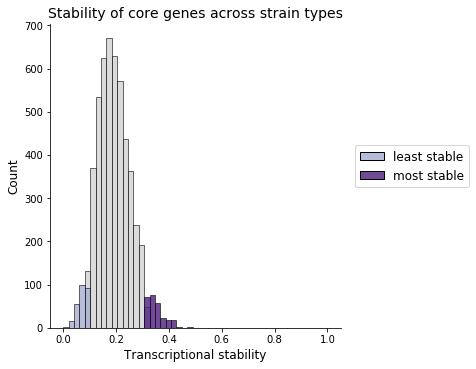

In [35]:
# Plot distribution of correlation scores
# This scores indicate how transcriptionally similar genes are across PAO1 and PA14 strains
fig_array = sns.displot(
    data=corr_summary_df,
    x="Transcriptional similarity across strains",
    hue="label",
    hue_order=["least stable", "most stable", ""],
    # label=["", "least stable", "most stable"],
    palette={"": "lightgrey", "least stable": "#a6aed0ff", "most stable": "#4e1c80"},
    legend=True,
    alpha=0.8,
    bins=np.linspace(0, 1, 50),
)
fig_array._legend.remove()

old_legend = fig_array._legend
handles = old_legend.legendHandles

legend = plt.legend(
    handles=[handles[0], handles[1]],
    labels=[
        fig_array._legend.texts[0].get_text(),
        fig_array._legend.texts[1].get_text(),
    ],
    bbox_to_anchor=(1.05, 0.6),
    loc="upper left",
    borderaxespad=0,
    fontsize=12,
)

plt.title("Stability of core genes across strain types", fontsize=14, y=1.1)
plt.xlabel("Transcriptional stability", fontsize=12)
plt.ylabel("Count", fontsize=12)

## Compare most stable core genes

We want to compare the most stable core genes obtained using the P. aeruginosa RNA-seq compendium vs the array compendium to validate our findings are robust.

In [36]:
pao1_rnaseq_similarity_scores_subset = pao1_rnaseq_similarity_scores[
    ["Transcriptional similarity across strains", "P-value", "Name", "label"]
]

In [37]:
all_similarity_scores = pao1_rnaseq_similarity_scores_subset.merge(
    corr_summary_df, left_index=True, right_index=True, suffixes=["_rnaseq", "_array"]
)

In [38]:
print(all_similarity_scores.shape)
all_similarity_scores.head()

(5339, 7)


,Transcriptional similarity across strains_rnaseq,P-value_rnaseq,Name,label_rnaseq,Transcriptional similarity across strains_array,P-value_array,label_array
PAO1 id,,,,,,,
PA0118,0.290443,1.771504e-104,NaN,NaN,0.124078,9.095392e-20,
PA1859,0.143328,5.986934e-26,NaN,NaN,0.161295,1.896545e-32,
PA3190,0.257508,9.170620e-82,NaN,NaN,0.213526,4.223950e-56,
PA1009,0.549950,0.000000e+00,NaN,NaN,0.349521,3.101977e-153,most stable
PA1065,0.329633,9.188709e-136,NaN,NaN,0.214398,1.481368e-56,


In [39]:
# Get most and least stable core genes
rnaseq_most_stable_genes = list(
    all_similarity_scores[all_similarity_scores["label_rnaseq"] == "most stable"].index
)
rnaseq_least_stable_genes = list(
    all_similarity_scores[all_similarity_scores["label_rnaseq"] == "least stable"].index
)

array_most_stable_genes = list(
    all_similarity_scores[all_similarity_scores["label_array"] == "most stable"].index
)
array_least_stable_genes = list(
    all_similarity_scores[all_similarity_scores["label_array"] == "least stable"].index
)

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


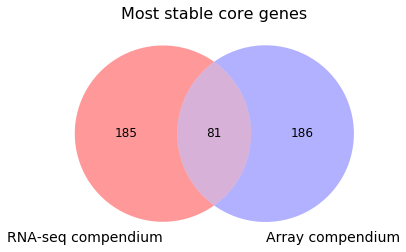

In [40]:
# Compare
most_stable_venn = venn2(
    [set(rnaseq_most_stable_genes), set(array_most_stable_genes)],
    set_labels=("RNA-seq compendium", "Array compendium"),
)

most_stable_venn.get_patch_by_id("11").set_color("purple")
most_stable_venn.get_patch_by_id("11").set_edgecolor("none")
most_stable_venn.get_patch_by_id("11").set_alpha(0.3)
most_stable_venn.get_patch_by_id("01").set_color("blue")
most_stable_venn.get_patch_by_id("01").set_edgecolor("none")
most_stable_venn.get_patch_by_id("01").set_alpha(0.3)

plt.title("Most stable core genes", fontsize=16, fontname="Verdana")
for text in most_stable_venn.set_labels:
    text.set_fontsize(14)
    text.set_fontname("Verdana")

for text in most_stable_venn.subset_labels:
    text.set_fontsize(12)
    text.set_fontname("Verdana")

# Save figure
plt.savefig(
    "most_stable_array_vs_rnaseq_venn.svg",
    format="svg",
    bbox_inches="tight",
    transparent=True,
    pad_inches=0,
    dpi=300,
)

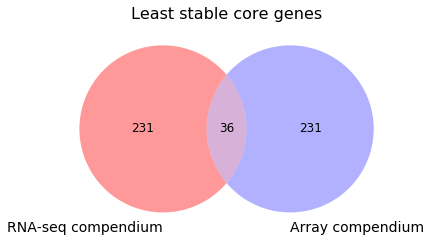

In [41]:
least_stable_venn = venn2(
    [set(rnaseq_least_stable_genes), set(array_least_stable_genes)],
    set_labels=("RNA-seq compendium", "Array compendium"),
)

least_stable_venn.get_patch_by_id("11").set_color("purple")
least_stable_venn.get_patch_by_id("11").set_edgecolor("none")
least_stable_venn.get_patch_by_id("11").set_alpha(0.3)
least_stable_venn.get_patch_by_id("01").set_color("blue")
least_stable_venn.get_patch_by_id("01").set_edgecolor("none")
least_stable_venn.get_patch_by_id("01").set_alpha(0.3)

plt.title("Least stable core genes", fontsize=16, fontname="Verdana")
for text in least_stable_venn.set_labels:
    text.set_fontsize(14)
    text.set_fontname("Verdana")

for text in least_stable_venn.subset_labels:
    text.set_fontsize(12)
    text.set_fontname("Verdana")


# Save figure
plt.savefig(
    "least_stable_array_vs_rnaseq_venn",
    format="svg",
    bbox_inches="tight",
    transparent=True,
    pad_inches=0,
    dpi=300,
)

### Plot correlation between transcriptional similarity values

In [42]:
# Calculate correlation
r, p = stats.pearsonr(
    all_similarity_scores["Transcriptional similarity across strains_rnaseq"],
    all_similarity_scores["Transcriptional similarity across strains_array"],
)

print(r, p)

0.5015362954290622 0.0


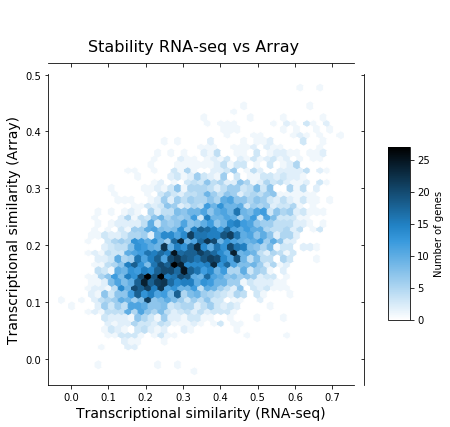

In [58]:
# Plot correlation
fig = sns.jointplot(
    data=all_similarity_scores,
    x="Transcriptional similarity across strains_rnaseq",
    y="Transcriptional similarity across strains_array",
    kind="hex",
    marginal_kws={"color": "white", "edgecolor": "white"},
)

cbar_ax = fig.fig.add_axes([0.9, 0.25, 0.05, 0.4])  # x, y, width, height
cb = plt.colorbar(cax=cbar_ax)
cb.set_label("Number of genes")

fig.set_axis_labels(
    "Transcriptional similarity (RNA-seq)",
    "Transcriptional similarity (Array)",
    fontsize=14,
    fontname="Verdana",
)
fig.fig.suptitle(
    "Stability RNA-seq vs Array", fontsize=16, fontname="Verdana", y=0.9, x=0.45
)

fig.savefig(
    "transcriptional_similarity_array_vs_rnaseq.svg",
    format="svg",
    bbox_inches="tight",
    transparent=True,
    pad_inches=0,
    dpi=300,
)

## Examine genes that differ

In [44]:
most_rnaseq_only = set(rnaseq_most_stable_genes).difference(array_most_stable_genes)
most_array_only = set(array_most_stable_genes).difference(rnaseq_most_stable_genes)

least_rnaseq_only = set(rnaseq_least_stable_genes).difference(array_least_stable_genes)
least_array_only = set(array_least_stable_genes).difference(rnaseq_least_stable_genes)

In [45]:
all_similarity_scores.loc[most_rnaseq_only]

,Transcriptional similarity across strains_rnaseq,P-value_rnaseq,Name,label_rnaseq,Transcriptional similarity across strains_array,P-value_array,label_array
PAO1 id,,,,,,,
PA5022,0.650908,0.0,NaN,most stable,0.176272,1.616248e-38,
PA4333,0.592148,0.0,NaN,most stable,0.250854,2.062039e-77,
PA5568,0.617898,0.0,NaN,most stable,0.298065,5.473722e-110,
PA1822,0.568396,0.0,fimL,most stable,0.198574,1.303222e-48,
PA4321,0.585214,0.0,NaN,most stable,0.251001,1.670054e-77,
...,...,...,...,...,...,...,...
PA2629,0.558366,0.0,purB,most stable,0.261933,1.770986e-84,
PA3795,0.573807,0.0,NaN,most stable,0.283493,3.078695e-99,
PA5004,0.610681,0.0,wapH,most stable,0.280708,2.960229e-97,


In [47]:
all_similarity_scores.loc[most_array_only]

,Transcriptional similarity across strains_rnaseq,P-value_rnaseq,Name,label_rnaseq,Transcriptional similarity across strains_array,P-value_array,label_array
PAO1 id,,,,,,,
PA3334,0.395940,2.873747e-200,NaN,NaN,0.320084,1.837521e-127,most stable
PA0626,0.490787,2.322109e-322,NaN,NaN,0.360287,2.216045e-163,most stable
PA2754,0.498932,0.000000e+00,NaN,NaN,0.323822,1.404041e-130,most stable
PA4229,0.327281,9.473147e-134,pchC,NaN,0.349849,1.541272e-153,most stable
PA2971,0.528012,0.000000e+00,NaN,NaN,0.342832,3.958197e-147,most stable
...,...,...,...,...,...,...,...
PA4611,0.506796,0.000000e+00,NaN,NaN,0.347986,8.054106e-152,most stable
PA0641,0.389212,5.209131e-193,NaN,NaN,0.340000,1.375662e-144,most stable
PA4469,0.440466,9.237748e-253,NaN,NaN,0.322889,8.500128e-130,most stable


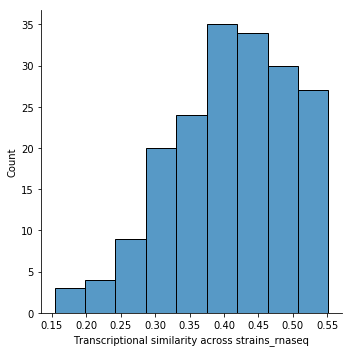

In [51]:
sns.displot(
    all_similarity_scores.loc[
        most_array_only, "Transcriptional similarity across strains_rnaseq"
    ]
)

In [49]:
all_similarity_scores.loc[least_rnaseq_only]

,Transcriptional similarity across strains_rnaseq,P-value_rnaseq,Name,label_rnaseq,Transcriptional similarity across strains_array,P-value_array,label_array
PAO1 id,,,,,,,
PA3954,0.133231,1.300336e-22,NaN,least stable,0.155438,3.156949e-30,
PA2650,0.119833,1.445108e-18,NaN,least stable,0.146449,5.530497e-27,
PA2447,0.135395,2.628461e-23,NaN,least stable,0.158136,3.066565e-31,
PA0832,0.108550,1.710646e-15,NaN,least stable,0.146826,4.083151e-27,
PA0814,0.129107,2.543210e-21,NaN,least stable,0.231851,4.336938e-66,
...,...,...,...,...,...,...,...
PA2837,0.132130,2.901336e-22,NaN,least stable,0.138560,2.668538e-24,
PA3835,0.049320,3.079749e-04,NaN,least stable,0.134590,5.241863e-23,
PA0979,0.085102,4.547851e-10,NaN,least stable,0.219861,1.883232e-59,


In [50]:
all_similarity_scores.loc[least_array_only]

,Transcriptional similarity across strains_rnaseq,P-value_rnaseq,Name,label_rnaseq,Transcriptional similarity across strains_array,P-value_array,label_array
PAO1 id,,,,,,,
PA5383,0.169190,1.217830e-35,NaN,NaN,0.079984,4.847797e-09,least stable
PA3661,0.274788,2.749568e-93,NaN,NaN,0.090569,3.360243e-11,least stable
PA2237,0.251177,9.354323e-78,pslG,NaN,0.035810,8.874942e-03,least stable
PA4658,0.333154,8.209156e-139,NaN,NaN,0.089699,5.172235e-11,least stable
PA3939,0.140997,3.711301e-25,NaN,NaN,0.083123,1.181336e-09,least stable
...,...,...,...,...,...,...,...
PA1629,0.189660,1.670831e-44,NaN,NaN,0.087544,1.478833e-10,least stable
PA3469,0.238619,3.897196e-70,NaN,NaN,0.046718,6.386075e-04,least stable
PA2806,0.286069,2.807630e-101,NaN,NaN,0.083988,7.930839e-10,least stable


In [ ]:
# Save
fig_array.savefig(
    array_similarity_dist_filename,
    format="svg",
    bbox_inches="tight",
    transparent=True,
    pad_inches=0,
    dpi=300,
)

**Takeaway:**
* Venn diagram comparing the most stable core genes using the array vs RNA-seq compendium, where the most stable genes = top 5% of genes with the highest transcriptional similarity.
* There is some consistency of most stable genes using the array and RNA-seq compendia
* Looking at the RNA-seq transcriptional similarity of the array only genes (191 genes), most of these genes were just below the threshold for "most stable" (transcriptional similarity = 0.4 - 0.55) according to the distribution plot. However there are some genes that have a lower similarity score (0.2 - 0.3). Why are these stable in microarray but not RNA-seq?

* I also plotted the results comparing the least stable genes across the compendium, but its less clear what this is telling us since these genes are those that have unstable profiles across strains.

In [ ]:
# Save transcriptional similarity df
corr_summary_df.to_csv(array_similarity_scores_filename, sep="\t")